<a href="https://colab.research.google.com/github/olaff13/week2hwlrstocks/blob/master/homework2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn
from sklearn.linear_model import Ridge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Conv1D, LSTM, Dense
from keras.callbacks import LearningRateScheduler
from tensorflow.keras.losses import Huber
from keras.optimizers import SGD

In [48]:
url = 'https://raw.githubusercontent.com/olaff13/week2hwlrstocks/master/KO.csv'
df = pd.read_csv(url)
df.set_index("Date", inplace=True)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-09-05,44.660000,45.419998,44.660000,45.380001,43.915051,10554900
2018-09-06,45.400002,46.000000,45.299999,45.770000,44.292458,11439400
2018-09-07,45.599998,45.820000,45.279999,45.720001,44.244076,10208100
2018-09-10,45.910000,46.310001,45.799999,46.060001,44.573093,8568900
2018-09-11,46.099998,46.150002,45.880001,46.020000,44.534389,9278300


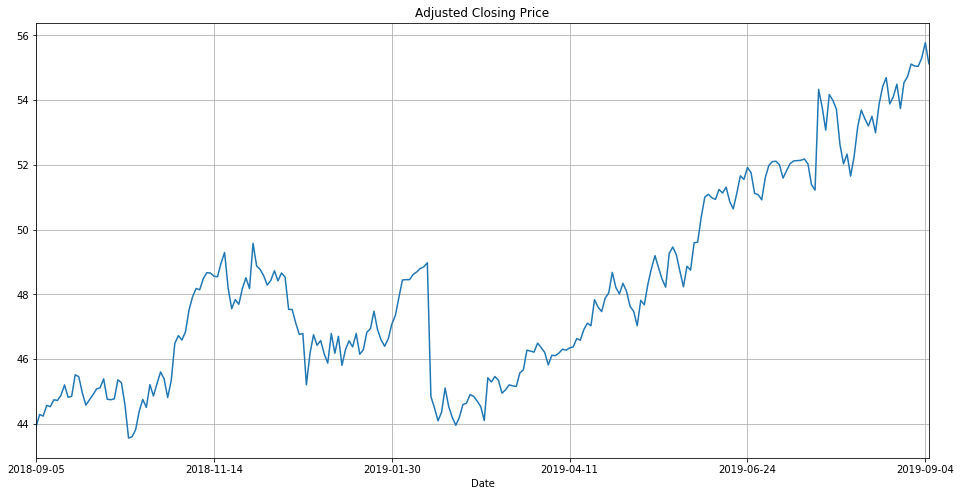

In [49]:
df["Adj Close"].plot(label="KO", figsize=(16,8), title="Adjusted Closing Price", grid=True)

In [0]:
window_size = 32
num_samples = len(df) - window_size
indices = np.arange(num_samples).astype(np.int)[:,None] + np.arange(window_size + 1).astype(np.int)
data = df["Adj Close"].values[indices] #2d matrix
X = data[:,:-1]
Y = data[:,-1]


In [0]:
#train and test split

split_fraction = 0.8
ind_split = int(split_fraction * num_samples)
X_train = X[:ind_split]
Y_train = Y[:ind_split]
X_test = X[ind_split:]
Y_test = Y[ind_split:]

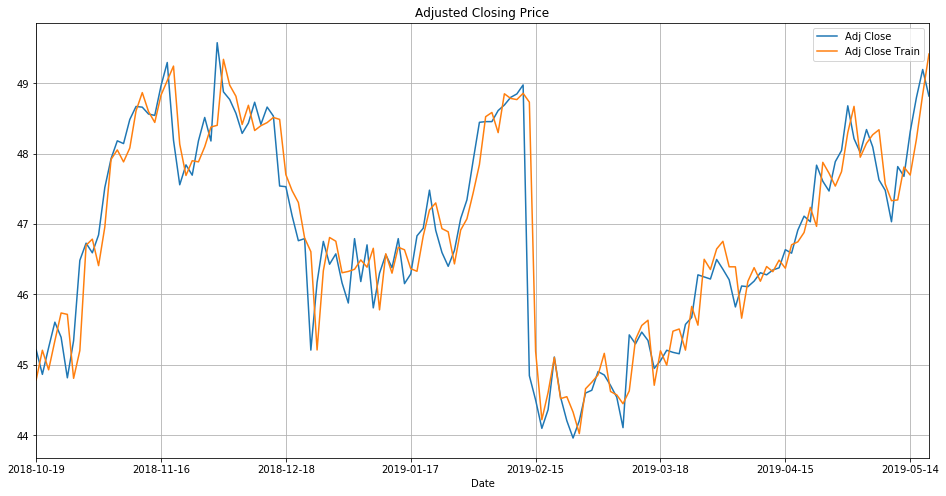

In [52]:
#Ridge Regression
ridge_model = Ridge()
ridge_model.fit(X_train, Y_train)
Y_pred_train_ridge = ridge_model.predict(X_train)
Y_pred_ridge = ridge_model.predict(X_test)
df_ridge = df.copy()
df_ridge.drop(["Open", "High", "Low", "Close", "Volume"], axis=1, inplace=True)
df_ridge = df_ridge.iloc[window_size:ind_split]
df_ridge["Adj Close Train"] = Y_pred_train_ridge[:-window_size]
df_ridge.plot(label="KO", figsize=(16, 8), title="Adjusted Closing Price", grid=True)

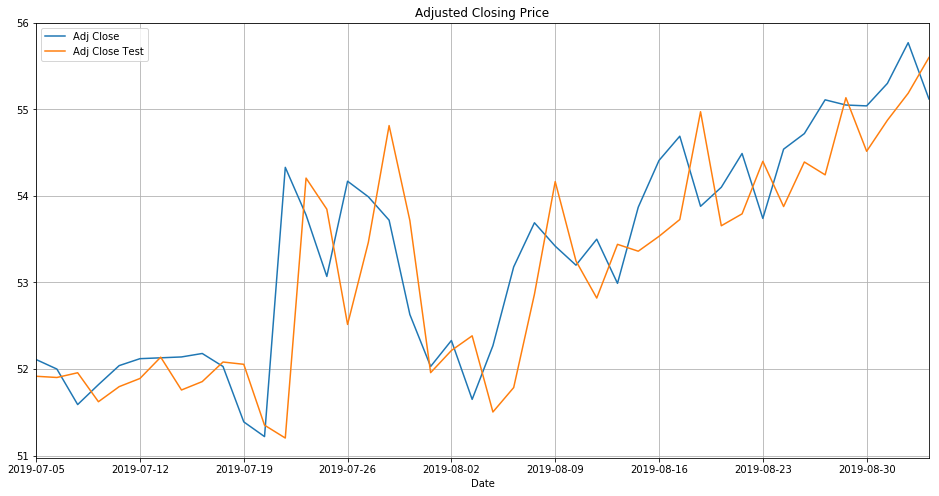

In [53]:
df_ridge = df.copy()
df_ridge.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_ridge = df_ridge.iloc[ind_split+window_size:]
df_ridge['Adj Close Test'] = Y_pred_ridge
df_ridge.plot(label='KO', figsize=(16,8), title='Adjusted Closing Price', grid=True)

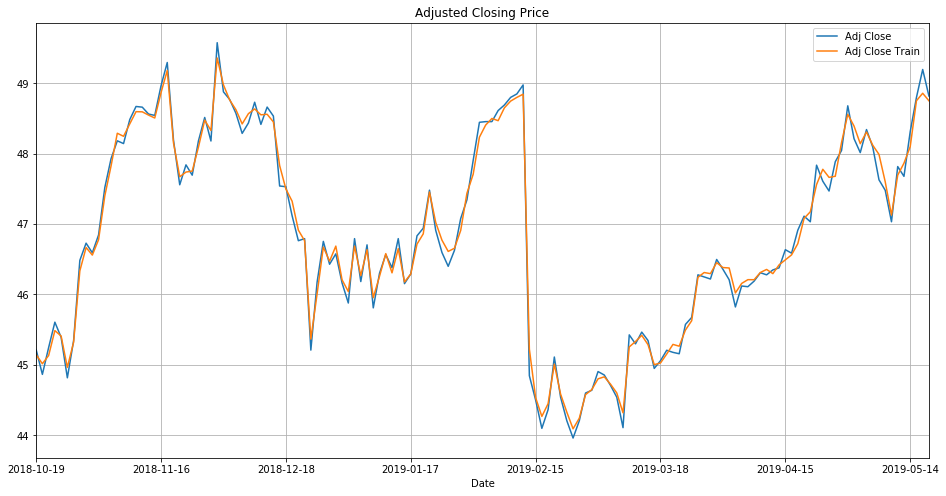

In [54]:
#Gradient Boosting Trees
gb_model = GradientBoostingRegressor()
gb_model.fit(X_train, Y_train)
Y_pred_train_gb = gb_model.predict(X_train)
Y_pred_gb = gb_model.predict(X_test)

df_gb = df.copy()
df_gb.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_gb = df_gb.iloc[window_size:ind_split] 
df_gb['Adj Close Train'] = Y_pred_train_gb[:-window_size]
df_gb.plot(label='KO', figsize=(16,8), title='Adjusted Closing Price', grid=True)

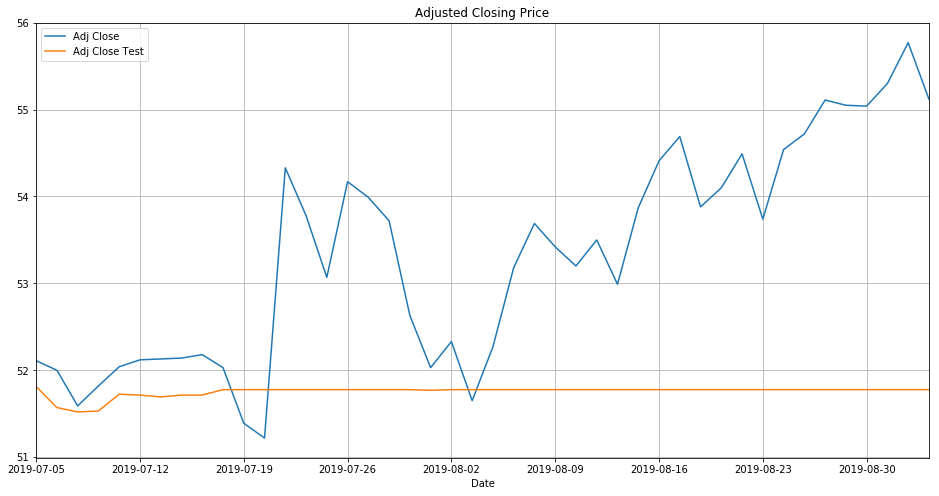

In [55]:
df_gb = df.copy()
df_gb.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_gb = df_gb.iloc[ind_split+window_size:] # Past 32 days we don't know yet
df_gb['Adj Close Test'] = Y_pred_gb
df_gb.plot(label='KO', figsize=(16,8), title='Adjusted Closing Price', grid=True)

In [56]:
#RNN
keras_model = Sequential([

  Conv1D(filters=128, kernel_size=5, input_shape=(window_size, 1), strides=1, padding="causal", activation="tanh"),

  Conv1D(filters=128, kernel_size=5, strides=1, padding="causal", activation="tanh"),

  LSTM(128, return_sequences=True),

  LSTM(128),

  Dense(64, activation="tanh"),

  Dense(64, activation="tanh"),

  Dense(1)

])

keras_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_5 (Conv1D)            (None, 32, 128)           768       
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 32, 128)           82048     
_________________________________________________________________
lstm_5 (LSTM)                (None, 32, 128)           131584    
_________________________________________________________________
lstm_6 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_7 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_8 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                

In [0]:
# figure out the right learning rate
lr_schedule = LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = SGD(lr=1e-8, momentum=0.9)
keras_model.compile(loss=Huber(),
                    optimizer=optimizer,
                    metrics=["mae"])
scaler = MinMaxScaler(feature_range=(-1, 1))
data_transform = scaler.fit_transform(df['Adj Close'].values[:,None])
data_transform = data_transform[indices]
X2 = data_transform[:,:-1]
y2 = data_transform[:,-1]
X_train_reshape = X2[:ind_split]
y_train_reshape = y2[:ind_split]
X_test_reshape = X2[ind_split:]
y_test_reshape = y2[ind_split:]

In [58]:
history = keras_model.fit(X_train_reshape, y_train_reshape, batch_size=256, epochs=250, callbacks=[lr_schedule], validation_data=(X_test_reshape, y_test_reshape))

Train on 176 samples, validate on 44 samples
Epoch 1/250
176/176 [==============================] - 3s 15ms/step - loss: 0.1275 - mean_absolute_error: 0.4428 - val_loss: 0.2189 - val_mean_absolute_error: 0.6281
Epoch 2/250
176/176 [==============================] - 0s 3ms/step - loss: 0.1275 - mean_absolute_error: 0.4428 - val_loss: 0.2189 - val_mean_absolute_error: 0.6281
Epoch 3/250
176/176 [==============================] - 0s 3ms/step - loss: 0.1275 - mean_absolute_error: 0.4428 - val_loss: 0.2189 - val_mean_absolute_error: 0.6281
Epoch 4/250
176/176 [==============================] - 0s 3ms/step - loss: 0.1275 - mean_absolute_error: 0.4428 - val_loss: 0.2189 - val_mean_absolute_error: 0.6281
Epoch 5/250
176/176 [==============================] - 0s 3ms/step - loss: 0.1275 - mean_absolute_error: 0.4428 - val_loss: 0.2189 - val_mean_absolute_error: 0.6281
Epoch 6/250
176/176 [==============================] - 0s 3ms/step - loss: 0.1275 - mean_absolute_error: 0.4428 - val_loss: 0.218

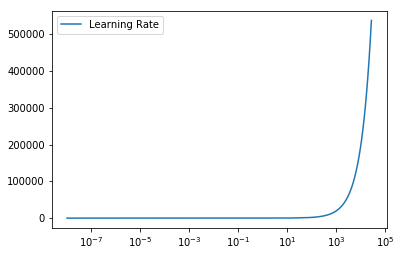

In [59]:
plt.semilogx(history.history['lr'], history.history['val_loss'])
plt.legend(['Learning Rate', 'Validation Loss'])

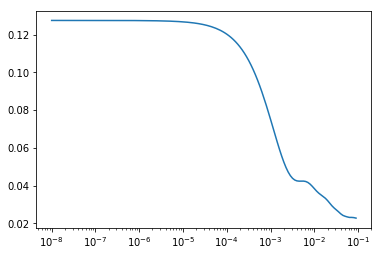

In [60]:
plt.semilogx(history.history['lr'][:140], history.history['loss'][:140])

In [61]:
keras_model = Sequential([
  Conv1D(filters=128, kernel_size=5, input_shape=(window_size, 1), strides=1, padding="causal", activation="tanh"),
  Conv1D(filters=128, kernel_size=5, strides=1, padding="causal", activation="tanh"),
  LSTM(128, return_sequences=True),
  LSTM(128),
  Dense(64, activation="tanh"),
  Dense(64, activation="tanh"),
  Dense(1)
])


optimizer = SGD(lr=0.1, momentum=0.9)
keras_model.compile(loss=Huber(),
                    optimizer=optimizer,
                    metrics=["mae"])
history = keras_model.fit(X_train_reshape, y_train_reshape, batch_size=256, epochs=250, validation_data=(X_test_reshape, y_test_reshape))

Train on 176 samples, validate on 44 samples
Epoch 1/250
176/176 [==============================] - 3s 15ms/step - loss: 0.1125 - mean_absolute_error: 0.4111 - val_loss: 0.3607 - val_mean_absolute_error: 0.8323
Epoch 2/250
176/176 [==============================] - 0s 3ms/step - loss: 0.0480 - mean_absolute_error: 0.2474 - val_loss: 0.4205 - val_mean_absolute_error: 0.9057
Epoch 3/250
176/176 [==============================] - 0s 3ms/step - loss: 0.1114 - mean_absolute_error: 0.4181 - val_loss: 0.2442 - val_mean_absolute_error: 0.6804
Epoch 4/250
176/176 [==============================] - 0s 3ms/step - loss: 0.0397 - mean_absolute_error: 0.2270 - val_loss: 0.1026 - val_mean_absolute_error: 0.4211
Epoch 5/250
176/176 [==============================] - 0s 3ms/step - loss: 0.0544 - mean_absolute_error: 0.2677 - val_loss: 0.0656 - val_mean_absolute_error: 0.3217
Epoch 6/250
176/176 [==============================] - 0s 3ms/step - loss: 0.0758 - mean_absolute_error: 0.3268 - val_loss: 0.087

In [0]:
y_pred_train_keras = scaler.inverse_transform(keras_model.predict(X_train_reshape, batch_size=256))
y_pred_keras = scaler.inverse_transform(keras_model.predict(X_test_reshape, batch_size=256))


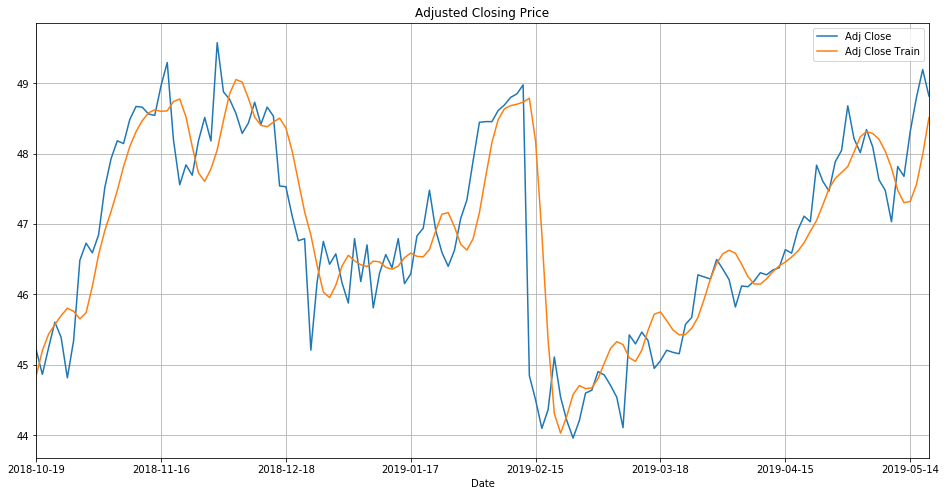

In [63]:
df_keras = df.copy()
df_keras.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_keras = df_keras.iloc[window_size:ind_split] 
df_keras['Adj Close Train'] = y_pred_train_keras[:-window_size]
df_keras.plot(label='KO', figsize=(16,8), title='Adjusted Closing Price', grid=True)

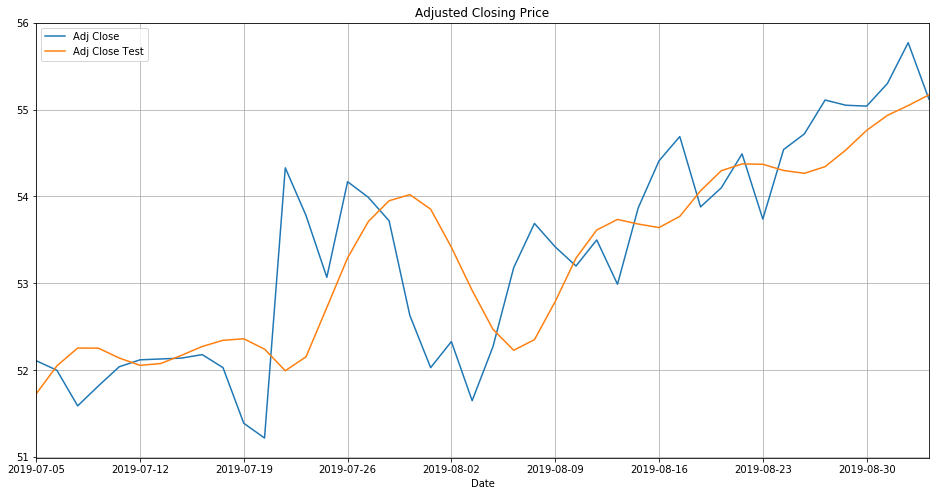

In [64]:
df_keras = df.copy()
df_keras.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_keras = df_keras.iloc[ind_split+window_size:]
df_keras['Adj Close Test'] = y_pred_keras
df_keras.plot(label='KO', figsize=(16,8), title='Adjusted Closing Price', grid=True)

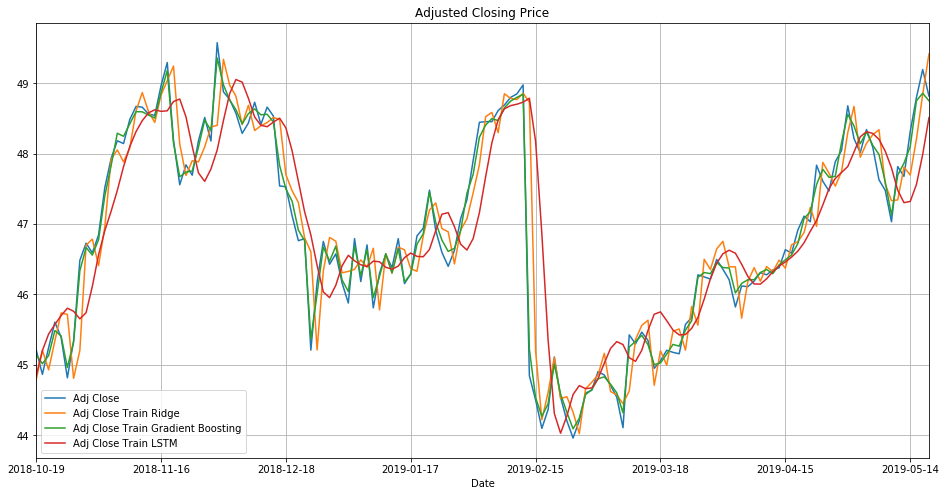

In [65]:
df_train = df.copy()
df_train.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_train = df_train.iloc[window_size:ind_split] 
df_train['Adj Close Train Ridge'] = Y_pred_train_ridge[:-window_size]
df_train['Adj Close Train Gradient Boosting'] = Y_pred_train_gb[:-window_size]
df_train['Adj Close Train LSTM'] = y_pred_train_keras[:-window_size]
df_train.plot(label='TSLA', figsize=(16,8), title='Adjusted Closing Price', grid=True)
